In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../../Desktop//samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../../Desktop//samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../../Desktop//samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../../Desktop//samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [4]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [5]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [17]:
n_classes = np.unique(y).size

Эти метки соответствуют:

* 1 - ходьбе
* 2 - подъему вверх по лестнице
* 3 - спуску по лестнице
* 4 - сидению
* 5 - стоянию
* 6 - лежанию

Отмасштабируйте выборку с помощью StandardScaler с параметрами по умолчанию.

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [9]:
PCA?

In [7]:
pca = PCA(random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [8]:
pca = PCA(0.9).fit(X_scaled)
print('We need %d components to explain 90%% of variance' 
      % pca.n_components_)

We need 65 components to explain 90% of variance


Вопрос 1:
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

* 65

In [9]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i])))

1 component: 51.0% of initial variance
2 component: 6.0% of initial variance
3 component: 3.0% of initial variance
4 component: 2.0% of initial variance
5 component: 2.0% of initial variance
6 component: 2.0% of initial variance
7 component: 1.0% of initial variance
8 component: 1.0% of initial variance
9 component: 1.0% of initial variance
10 component: 1.0% of initial variance
11 component: 1.0% of initial variance
12 component: 1.0% of initial variance
13 component: 1.0% of initial variance
14 component: 1.0% of initial variance
15 component: 1.0% of initial variance
16 component: 1.0% of initial variance
17 component: 1.0% of initial variance
18 component: 1.0% of initial variance
19 component: 1.0% of initial variance
20 component: 1.0% of initial variance
21 component: 1.0% of initial variance
22 component: 1.0% of initial variance
23 component: 0.0% of initial variance
24 component: 0.0% of initial variance
25 component: 0.0% of initial variance
26 component: 0.0% of initial var

In [10]:
round(100 * pca.explained_variance_ratio_[0])

51.0

Вопрос 2:
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

* 51

Projecting 561-dimensional data to 2D


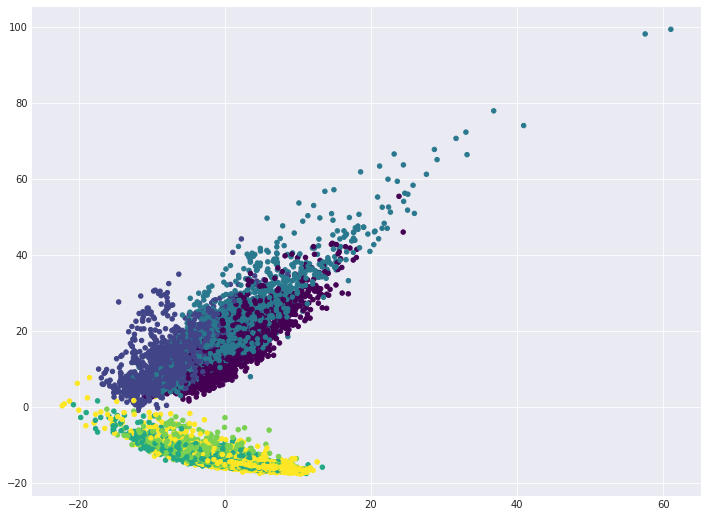

In [107]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)
print('Projecting %d-dimensional data to 2D' % X.shape[1])
plt.scatter(X_reduced[:, 1], X_reduced[:, 0], c=y, s=20, cmap='viridis')
plt.show()

Вопрос 3:
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?

* 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)

In [108]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

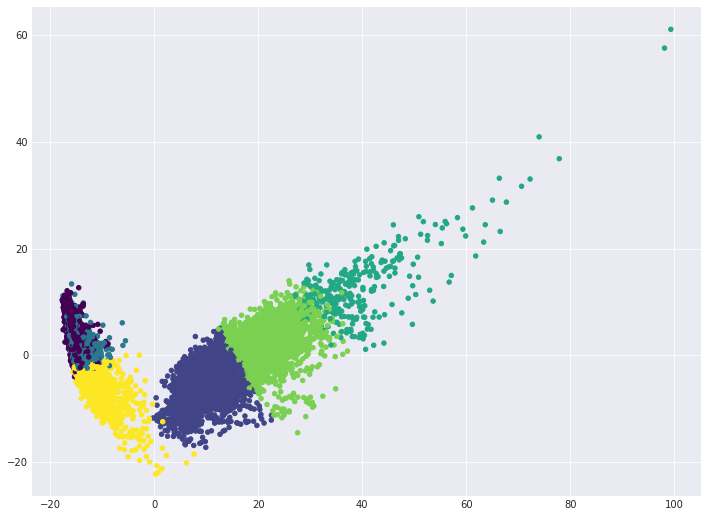

In [109]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels_, s=20,  cmap='viridis');


In [110]:
tab = pd.crosstab(y, kmeans.labels_, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,0,77,742,0,1722
подъем вверх по лестнице,0,1242,0,5,295,2,1544
спуск по лестнице,0,321,0,196,889,0,1406
сидение,91,1,1234,0,0,451,1777
стояние,0,0,1340,0,0,566,1906
лежание,1556,5,53,0,0,330,1944
все,1647,2472,2627,278,1926,1349,10299


In [111]:
pd.Series(tab.iloc[:-1,:-1].max(axis=1).values / 
          tab.iloc[:-1,-1].values, index=tab.index[:-1])

ходьба                      0.524390
подъем вверх по лестнице    0.804404
спуск по лестнице           0.632290
сидение                     0.694429
стояние                     0.703043
лежание                     0.800412
dtype: float64

In [104]:
1340/1906

0.7030430220356768

In [105]:
889/1544

0.5757772020725389

In [101]:
903/1722

0.524390243902439

In [102]:
1242/1544

0.8044041450777202

In [103]:
1556/1944

0.8004115226337448

In [18]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

C:\Users\maksn_000\anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


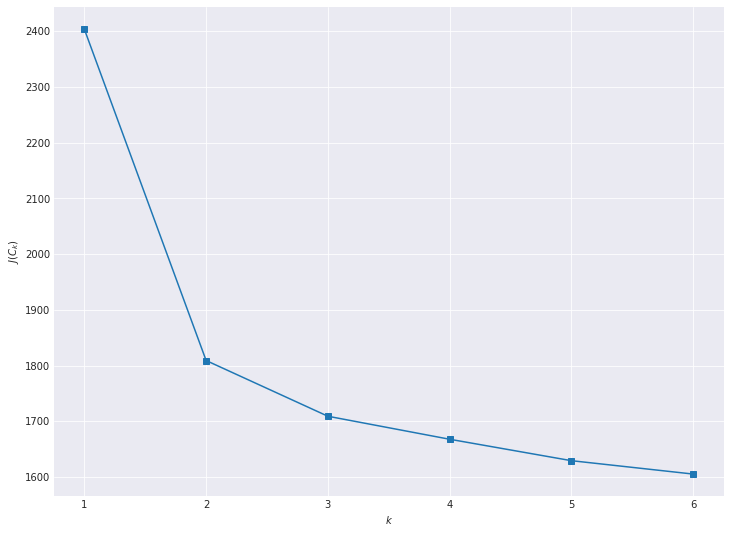

In [19]:
plt.plot(range(1, n_classes + 1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [112]:
d = {}
for k in range(2, 6):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

In [113]:
d

{2: 0.16816296144852402,
 3: 0.41307462109843374,
 4: 0.9311984341132017,
 5: 0.6248742631772773}

Вопрос 5:
Какое количество кластеров оптимально выбрать, согласно методу локтя?

* 3

In [20]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

In [30]:
algorithms = []
algorithms.append(kmeans)
algorithms.append(ag)

data = []
for algo in algorithms:
    data.append(({
        'ARI': metrics.adjusted_rand_score(y, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['ARI'],
                       index=['K-means', 
                               'Agglomerative'])

results

,ARI
K-means,0.419224
Agglomerative,0.459875


Вопрос 6:
Отметьте все верные утверждения.

* Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
* В случае случайного разбиения на кластеры ARI будет близок к нулю

In [50]:
train_part_size = int(.7 * X.shape[0])

X_train, X_test = X[:train_part_size, :], X[train_part_size:, :]
y_train, y_test = y[:train_part_size], y[train_part_size:]

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Вопрос 7
Какое значение гиперпараметра C было выбрано лучшим по итогам кросс-валидации?

* 0.1

In [33]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [114]:
%%time
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
best_svc.fit(X_train_scaled, y_train)

Wall time: 23.9 s


C:\Users\maksn_000\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [82]:
best_svc.best_params_

{'C': 0.1}

In [123]:
best_svc.best_score_

0.9341101401026495

In [116]:
y_predicted = best_svc.predict(X_test_scaled)

In [54]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,526,2,0,0,0,0,528
подъем вверх по лестнице,13,487,1,0,0,0,501
спуск по лестнице,3,5,438,1,1,0,448
сидение,0,4,0,446,62,0,512
стояние,0,0,0,16,516,0,532
лежание,0,0,0,0,11,558,569
все,542,498,439,463,590,558,3090


Вопрос 8:
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты?

* по точности – стояние, по полноте – сидение

In [117]:
print(metrics.classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98       528
           2       0.98      0.97      0.97       501
           3       1.00      0.98      0.99       448
           4       0.96      0.87      0.91       512
           5       0.87      0.97      0.92       532
           6       1.00      0.98      0.99       569

    accuracy                           0.96      3090
   macro avg       0.96      0.96      0.96      3090
weighted avg       0.96      0.96      0.96      3090



In [118]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [119]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [120]:
%%time
best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=1, cv=3, verbose=1)
best_svc_pca.fit(X_train_pca, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\maksn_000\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\maksn_000\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\maksn_000\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\maksn_000\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\maksn_000\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: Convergenc

Wall time: 10.8 s


C:\Users\maksn_000\anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [121]:
best_svc_pca.best_params_, best_svc_pca.best_score_

({'C': 10}, 0.9005409904286309)

In [124]:
round(100 * (best_svc_pca.best_score_ - best_svc.best_score_))

-3.0

Вопрос 9:
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.

* Качество одинаковое

Вопрос 10:
Выберите все верные утверждения:

* PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
* PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком